# This is the second assignment regarding neural networks in the contect of the computational intelligence course. In this assignment , a regression problem is solved with the use of RBF networks

In [1]:
# first import all necessary libraries
from __future__ import print_function, absolute_import, division
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from math import sqrt
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score,mean_squared_error
from keras.initializers import Initializer, Constant
from keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.cluster import KMeans
boston_dataset=load_boston()

### As our goal is to develop a model that has the capacity of predicting the value of houses, we will split the dataset into features and the target variable. And store them in features and prices variables, respectively
 - The features ‘RM’, ‘LSTAT’, give us quantitative information abouth each datapoint. We will store them in features.
 - The target variable, ‘PRICE’, will be the variable we seek to predict. We will store it in target.

In [2]:
# import dataset and use pandas dataframe to desribe the dataset and have a great first look on the data
#We also adds the target variable to the dataframe from boston.target
x_train= boston_dataset
boston_dataset.DESCR
data=pd.DataFrame(boston_dataset.data,columns=boston_dataset.feature_names)
data['PRICE']=boston_dataset.target
features = ['LSTAT', 'RM']
target = data['PRICE']
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### After loading the data , it is a good practise to check whether there are any missing values in the data. Wecount the number of missing values for each feature using .isnull() . 

In [3]:

data.isnull().sum()
X_rooms = data.RM
y_price = data.PRICE


X_rooms = np.array(X_rooms).reshape(-1,1)
y_price = np.array(y_price).reshape(-1,1)


In [4]:
prices = data['PRICE']
features = data.drop('PRICE', axis = 1)
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 506 data points with 14 variables each.


In [5]:
#The Boston housing dataset is split into training and testing subsets, with the given analogy of 75-25 %
X_train, X_test, Y_train, Y_test = train_test_split(X_rooms, y_price, test_size = 0.25, random_state=5)
split_size = int(X_train.shape[0]*0.8)
X_train, X_val = X_train[:split_size], X_train[split_size:]
Y_train, Y_val = Y_train[:split_size], Y_train[split_size:]
# define three number of hidden layer neurons as required
rbf_neurons1=round(0.1*len(X_train))
rbf_neurons2=round(0.5*len(X_train))
rbf_neurons3=round(0.9*len(X_train))


In [6]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [7]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [8]:
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),trainable=True)
                                     # initializer='ones',
                                     
        super(RBFLayer, self).build(input_shape)
    def initialize_stds(self,X):
        self.centers, _ = kmeans(X, self.output_dim)
        dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.stds = np.repeat(dMax / np.sqrt(2*self.output_dim), self.output_dim)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
#define necessary constants and optimizer. Three different rbf layers according to the three different rbf networks 
#we need to pass an initial value for betas for the process to begin properly. Betas initial value has a small affect
# on the model's perfomance
n_outputs=128
SGD_learning_rate=0.001
opt=tf.keras.optimizers.SGD(learning_rate=SGD_learning_rate)
rbflayer1 = RBFLayer(rbf_neurons1,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
rbflayer2 = RBFLayer(rbf_neurons2,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
rbflayer3 = RBFLayer(rbf_neurons3,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
#initialize all rbf layer's standard deviations
rbflayer1.initialize_stds(X_train)
rbflayer2.initialize_stds(X_train)
rbflayer3.initialize_stds(X_train)
#define first rbf network 
model_1=tf.keras.Sequential()
model_1.add(rbflayer1)
model_1.add(layers.Dense(n_outputs))
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,metrics=['accuracy'])
history1=model_1.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 52ms/step - loss: 4.8280 - accuracy: 0.0033 - val_loss: 4.8515 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 4.8250 - accuracy: 0.0033 - val_loss: 4.8488 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8221 - accuracy: 0.0033 - val_loss: 4.8461 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8193 - accuracy: 0.0033 - val_loss: 4.8434 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8163 - accuracy: 0.0033 - val_loss: 4.8408 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8135 - accuracy: 0.0033 - val_loss: 4.8381 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 4.8106 - accuracy: 0.0033 - val_loss: 4.8354 - val_accu

10/10 [==============================] - 0s 3ms/step - loss: 4.6693 - accuracy: 0.0099 - val_loss: 4.7046 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 3ms/step - loss: 4.6666 - accuracy: 0.0099 - val_loss: 4.7020 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 3ms/step - loss: 4.6638 - accuracy: 0.0099 - val_loss: 4.6995 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 3ms/step - loss: 4.6610 - accuracy: 0.0099 - val_loss: 4.6970 - val_accuracy: 0.0000e+00
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 4.6583 - accuracy: 0.0099 - val_loss: 4.6945 - val_accuracy: 0.0000e+00
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 4.6556 - accuracy: 0.0099 - val_loss: 4.6920 - val_accuracy: 0.0000e+00
Epoch 63/100
10/10 [==============================] - 0s 3ms/step - loss: 4.6528 - accuracy: 0.0099 - val_loss: 4.6895 - val_accuracy: 0.

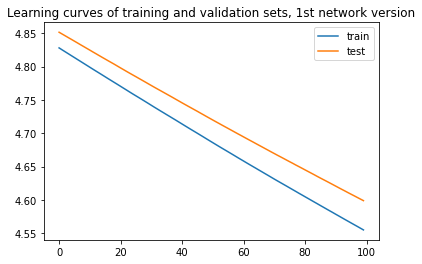

R^2 is: -8.027917758230263
RMSE is: 27.297916046329266


In [10]:
plt.figure(1)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.title('Learning curves of training and validation sets, 1st network version')
plt.show()
y_pred1=model_1.predict(X_test)

print("R^2 is: "+str(r2_score(Y_test,y_pred1.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred1.argmax(axis=1)))) )

In [11]:
#define second rbf network
model_2=tf.keras.Sequential()
model_2.add(rbflayer2)
model_2.add(layers.Dense(n_outputs))
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,metrics=['accuracy'])
history2=model_2.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 17ms/step - loss: 5.0699 - accuracy: 0.0000e+00 - val_loss: 4.9228 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 5.0504 - accuracy: 0.0000e+00 - val_loss: 4.9055 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 5.0311 - accuracy: 0.0000e+00 - val_loss: 4.8883 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 5.0118 - accuracy: 0.0000e+00 - val_loss: 4.8712 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9926 - accuracy: 0.0000e+00 - val_loss: 4.8544 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9733 - accuracy: 0.0000e+00 - val_loss: 4.8375 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9546 - accuracy: 0.0000e+00 - 

10/10 [==============================] - 0s 3ms/step - loss: 4.2097 - accuracy: 0.0330 - val_loss: 4.1695 - val_accuracy: 0.0132
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 4.1993 - accuracy: 0.0330 - val_loss: 4.1610 - val_accuracy: 0.0132
Epoch 60/100
10/10 [==============================] - 0s 3ms/step - loss: 4.1892 - accuracy: 0.0330 - val_loss: 4.1523 - val_accuracy: 0.0132
Epoch 61/100
10/10 [==============================] - 0s 3ms/step - loss: 4.1791 - accuracy: 0.0330 - val_loss: 4.1438 - val_accuracy: 0.0132
Epoch 62/100
10/10 [==============================] - 0s 3ms/step - loss: 4.1694 - accuracy: 0.0297 - val_loss: 4.1352 - val_accuracy: 0.0132
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 4.1597 - accuracy: 0.0297 - val_loss: 4.1266 - val_accuracy: 0.0132
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 4.1499 - accuracy: 0.0297 - val_loss: 4.1186 - val_accuracy: 0.0132
Epoch 65/100
10/10 

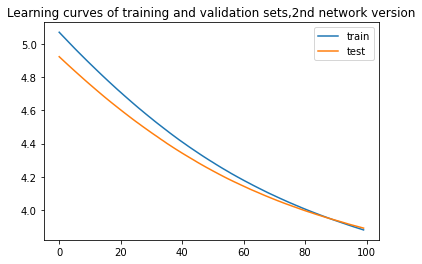

R^2 is: -1.0797964018718713
RMSE is: 13.102256823092262


In [12]:
plt.figure(1)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.title('Learning curves of training and validation sets,2nd network version')
plt.show()
y_pred2=model_2.predict(X_test)

print("R^2 is: "+str(r2_score(Y_test,y_pred2.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred2.argmax(axis=1)))) )

In [13]:
#define third rbf network
model_3=tf.keras.Sequential()
model_3.add(rbflayer3)
model_3.add(layers.Dense(n_outputs))
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt, metrics=['accuracy'])
history3=model_3.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Epoch 1/100
10/10 [==============================] - 0s 18ms/step - loss: 5.0957 - accuracy: 0.0000e+00 - val_loss: 5.0222 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 5.0546 - accuracy: 0.0000e+00 - val_loss: 4.9848 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 5.0140 - accuracy: 0.0000e+00 - val_loss: 4.9484 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 4.9741 - accuracy: 0.0000e+00 - val_loss: 4.9120 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9347 - accuracy: 0.0000e+00 - val_loss: 4.8766 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8963 - accuracy: 0.0000e+00 - val_loss: 4.8416 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8586 - accuracy: 0.0000e+00 - 

Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 3.8312 - accuracy: 0.0132 - val_loss: 3.8919 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 3.8220 - accuracy: 0.0132 - val_loss: 3.8839 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 3.8128 - accuracy: 0.0132 - val_loss: 3.8762 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 3.8047 - accuracy: 0.0198 - val_loss: 3.8672 - val_accuracy: 0.0000e+00
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 3.7955 - accuracy: 0.0198 - val_loss: 3.8601 - val_accuracy: 0.0000e+00
Epoch 62/100
10/10 [==============================] - 0s 5ms/step - loss: 3.7872 - accuracy: 0.0198 - val_loss: 3.8518 - val_accuracy: 0.0000e+00
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 3.7790 - accuracy: 0.0165 - val_loss: 3.8438 - val

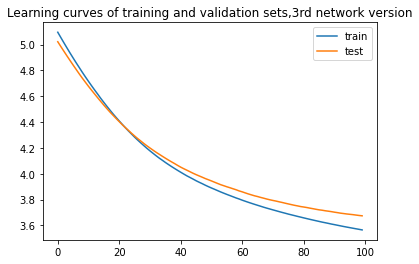

R^2 is: -0.3888515730646729
RMSE is: 10.706896739731619


In [14]:
plt.figure(1)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.title('Learning curves of training and validation sets,3rd network version')
plt.show()
y_pred3=model_3.predict(X_test)

print("R^2 is: "+str(r2_score(Y_test,y_pred3.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred3.argmax(axis=1)))) )

## RBF network fine tuning
### This is the second part of this assignment where the purpose is to perform finding of optimal values for some hyperparameters of the network, and the final extraction of theand justification of a model on the basis of the selected values.
### The RBF network considered in this section will have the same architecture as the above models, with the additional addition of drop out normalization for the neurons of the output layer.

In [15]:
#Import keras tuner to help create hypermodels of our model
import keras_tuner as kt
value1=round(0.05*len(X_train))
value2=round(0.15*len(X_train))
value3=round(0.30*len(X_train))
value4=round(0.5*len(X_train))

# Define the model using a function method
The model used for tuning of hyperparameters is called hypermodel. Define hypermodel using a build function

In [16]:
def build_model(hyperparameters):
    hp_learning_rate=0.001
    hp_units1=hyperparameters.Choice('units_1',values=[value1,value2,value3,value4])
    hp_units2=hyperparameters.Choice('units_2',values=[32,64,128,256])
    dropout_prob=hyperparameters.Choice('dropout',values=[0.2,0.35,0.5])
    #add the RBF hidden layer tuned according to the number of its neurons
    rbflayer_tuned = RBFLayer(hp_units1,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
    #initiliaze stds using custom made function
    rbflayer_tuned.initialize_stds(X_train)
    model=tf.keras.Sequential()
    model.add(rbflayer_tuned)
    model.add(layers.Dense(units=hp_units2))
    model.add(layers.Dropout(dropout_prob))
    #compile the model using RMSprop optimizer and fmeasure as a metric, loss function remains categorical cross-entropy
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),loss=['mse'],metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()]
)
    return model


In [17]:
#fit the model 
 
tuner=kt.Hyperband(build_model,objective="val_accuracy",max_epochs=10,directory='my_dir',project_name='My_tuner',overwrite=True)

tuner.search(X_train,Y_train, epochs=100, validation_split=0.2)

Trial 30 Complete [00h 00m 01s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.016393441706895828
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_hyperparams=tuner.get_best_hyperparameters(num_trials=1)[0]

h_model = tuner.hypermodel.build(best_hyperparams)
h_model.summary()
eval_result=h_model.evaluate(X_test,Y_test)

print(h_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 152)               304       
_________________________________________________________________
dense (Dense)                (None, 64)                9792      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
Total params: 10,096
Trainable params: 10,096
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 2ms/step - loss: 569.4510 - accuracy: 0.0000e+00 - root_mean_squared_error: 23.8632


In [19]:
history_hypermodel=h_model.fit( X_train, Y_train, epochs=200, validation_split=0.2)

Epoch 1/200
8/8 [==============================] - 0s 9ms/step - loss: 589.8580 - accuracy: 0.0000e+00 - root_mean_squared_error: 24.2870 - val_loss: 579.1689 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 24.0659
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 580.9877 - accuracy: 0.0000e+00 - root_mean_squared_error: 24.1037 - val_loss: 571.3549 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 23.9030
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 572.5984 - accuracy: 0.0000e+00 - root_mean_squared_error: 23.9290 - val_loss: 563.6478 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 23.7413
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 564.1420 - accuracy: 0.0041 - root_mean_squared_error: 23.7517 - val_loss: 556.1781 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 23.5834
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 555.6787 - accuracy: 0.0000e+00 -

8/8 [==============================] - 0s 4ms/step - loss: 374.9233 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.3629 - val_loss: 376.6886 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 19.4085
Epoch 38/200
8/8 [==============================] - 0s 4ms/step - loss: 368.7268 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.2023 - val_loss: 372.9380 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 19.3116
Epoch 39/200
8/8 [==============================] - 0s 5ms/step - loss: 367.3846 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.1673 - val_loss: 369.3100 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 19.2174
Epoch 40/200
8/8 [==============================] - 0s 3ms/step - loss: 361.3653 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.0096 - val_loss: 365.7727 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 19.1252
Epoch 41/200
8/8 [==============================] - 0s 4ms/step - loss: 357.3434 - accuracy: 0.0000e+00 - roo

Epoch 73/200
8/8 [==============================] - 0s 4ms/step - loss: 287.7951 - accuracy: 0.0041 - root_mean_squared_error: 16.9645 - val_loss: 288.1961 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 16.9763
Epoch 74/200
8/8 [==============================] - 0s 4ms/step - loss: 289.4202 - accuracy: 0.0000e+00 - root_mean_squared_error: 17.0124 - val_loss: 286.7372 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 16.9333
Epoch 75/200
8/8 [==============================] - 0s 4ms/step - loss: 288.7292 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.9920 - val_loss: 285.3298 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 16.8917
Epoch 76/200
8/8 [==============================] - 0s 4ms/step - loss: 285.7722 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.9048 - val_loss: 283.9489 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 16.8508
Epoch 77/200
8/8 [==============================] - 0s 4ms/step - loss: 284.3781 - accuracy: 0.0000e

Epoch 109/200
8/8 [==============================] - 0s 5ms/step - loss: 255.4276 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.9821 - val_loss: 250.7423 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.8348
Epoch 110/200
8/8 [==============================] - 0s 4ms/step - loss: 256.1662 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.0052 - val_loss: 250.0198 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.8120
Epoch 111/200
8/8 [==============================] - 0s 4ms/step - loss: 257.8071 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.0564 - val_loss: 249.3077 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.7895
Epoch 112/200
8/8 [==============================] - 0s 4ms/step - loss: 254.2440 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.9450 - val_loss: 248.6105 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.7674
Epoch 113/200
8/8 [==============================] - 0s 5ms/step - loss: 252.5728 - accuracy

8/8 [==============================] - 0s 4ms/step - loss: 234.1883 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.3032 - val_loss: 228.7437 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.1243
Epoch 146/200
8/8 [==============================] - 0s 4ms/step - loss: 235.0217 - accuracy: 0.0041 - root_mean_squared_error: 15.3304 - val_loss: 228.2260 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.1072
Epoch 147/200
8/8 [==============================] - 0s 5ms/step - loss: 235.7467 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.3540 - val_loss: 227.7322 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.0908
Epoch 148/200
8/8 [==============================] - 0s 5ms/step - loss: 233.8516 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.2922 - val_loss: 227.2401 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 15.0745
Epoch 149/200
8/8 [==============================] - 0s 4ms/step - loss: 234.8709 - accuracy: 0.0000e+00 - roo

8/8 [==============================] - 0s 3ms/step - loss: 218.8365 - accuracy: 0.0041 - root_mean_squared_error: 14.7931 - val_loss: 211.5449 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 14.5446
Epoch 182/200
8/8 [==============================] - 0s 3ms/step - loss: 219.7375 - accuracy: 0.0041 - root_mean_squared_error: 14.8235 - val_loss: 211.1035 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 14.5294
Epoch 183/200
8/8 [==============================] - 0s 3ms/step - loss: 219.1497 - accuracy: 0.0000e+00 - root_mean_squared_error: 14.8037 - val_loss: 210.6572 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 14.5140
Epoch 184/200
8/8 [==============================] - 0s 4ms/step - loss: 218.3537 - accuracy: 0.0000e+00 - root_mean_squared_error: 14.7768 - val_loss: 210.2047 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 14.4984
Epoch 185/200
8/8 [==============================] - 0s 4ms/step - loss: 217.1398 - accuracy: 0.0083 - root_mean_s

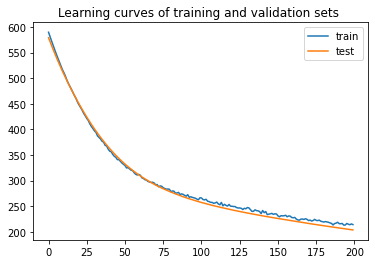

In [20]:
plt.figure(1)
plt.plot(history_hypermodel.history['loss'], label='train')
plt.plot(history_hypermodel.history['val_loss'], label='test')
plt.legend()
plt.title('Learning curves of training and validation sets ')
plt.show()